In [1]:
import numpy as np

import fastdfe as fd

p = fd.Parser(
    n=10,
    vcf="../../resources/genome/betula/all.vcf.gz",
    stratifications=[fd.DegeneracyStratification(), fd.BaseTransitionStratification()]
)

# parse SFS
s: fd.Spectra = p.parse()

Counting sites: 2439037it [00:41, 58823.11it/s]
INFO:fastdfe.Parser: Using stratification: [neutral, selected].[A>C, A>G, A>T, C>A, C>G, C>T, G>A, G>C, G>T, T>A, T>C, T>G].
INFO:fastdfe.Parser: Starting to parse.
Processing sites: 100%|██████████| 2439037/2439037 [05:30<00:00, 7388.54it/s] 
INFO:fastdfe.PolyAllelicFiltration: Filtered out 0 sites.
INFO:fastdfe.DegeneracyStratification: Number of sites with valid type: 91224 / 1548617
INFO:fastdfe.BaseTransitionStratification: Number of sites with valid type: 91224 / 981644
INFO:fastdfe.Parser: Included 91224 out of 2439037 sites in total.


<Axes: xlabel='frequency'>

<Figure size 512x384 with 0 Axes>

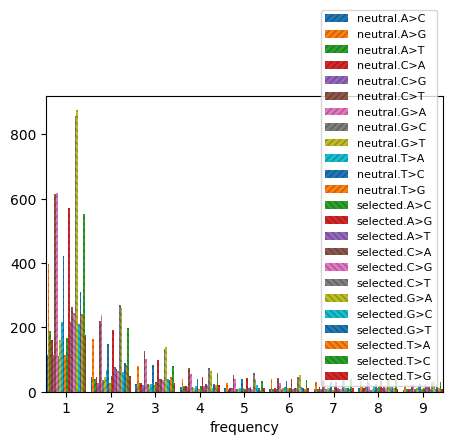

In [2]:
s.plot()

In [32]:
# extract neutral and selected SFS
neut = s['neutral.*'].merge_groups(1)
sel = s['selected.*'].merge_groups(1)

# create inference objects
inferences = [fd.BaseInference(
    sfs_neut=neut[t],
    sfs_sel=sel[t],
    model=fd.DiscreteFractionalParametrization(np.array([-100000, -100, -10, -1, 1, 1000])),
    do_bootstrap=True
) for t in neut.types]

In [33]:
# run inference
[i.run() for i in inferences]

INFO:fastdfe.Discretization: Precomputing linear DFE-SFS transformation using midpoint integration.
INFO:fastdfe.BaseInference: Successfully finished optimization after 19 iterations and 138 function evaluations, obtaining a log-likelihood of -24.914217983522075.
INFO:fastdfe.BaseInference: Inferred parameters: {'all.S1': 0.0, 'all.S2': 0.0, 'all.S3': 0.4594999163725839, 'all.S4': 0.8564984167403228, 'all.eps': 0.0}.
Bootstrapping: 100%|██████████| 100/100 [00:00<00:00, 129.01it/s]
INFO:fastdfe.Discretization: Precomputing linear DFE-SFS transformation using midpoint integration.
INFO:fastdfe.BaseInference: Successfully finished optimization after 20 iterations and 138 function evaluations, obtaining a log-likelihood of -30.022839771992494.
INFO:fastdfe.BaseInference: Inferred parameters: {'all.S1': 0.0, 'all.S2': 0.0, 'all.S3': 0.3600023106856762, 'all.S4': 1.0, 'all.eps': 0.0}.
Bootstrapping: 100%|██████████| 100/100 [00:00<00:00, 202.65it/s]
INFO:fastdfe.Discretization: Precomputing

<Axes: title={'center': 'parameter estimates'}>

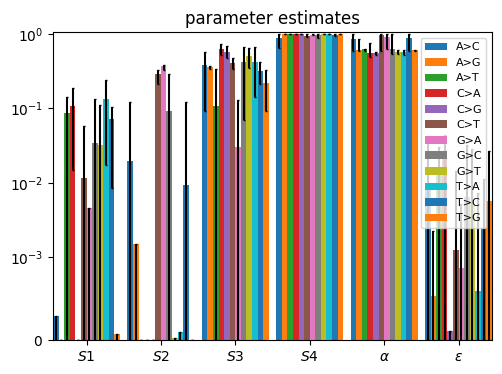

In [34]:
fd.Inference.plot_inferred_parameters(inferences, labels=neut.types)

<Axes: title={'center': 'discretized DFEs'}, xlabel='S', ylabel='fraction'>

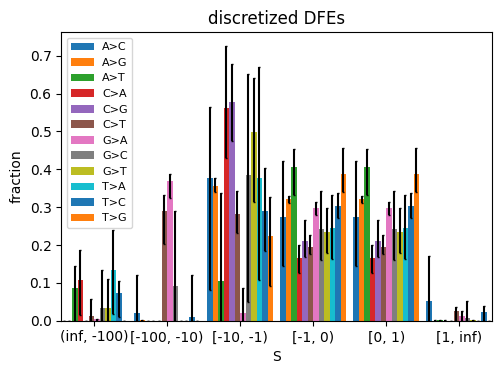

In [35]:
fd.Inference.plot_discretized(inferences, labels=neut.types)

In [31]:
inf = fd.JointInference(
    sfs_neut=neut,
    sfs_sel=sel,
    shared_params=[fd.SharedParams(params=['p_b', 'S_b'], types='all')],
    covariates=[fd.Covariate(
        param='S3',
        values=dict((t, int(t not in ['A>T', 'T>A', 'G>C', 'C>G'])) for t in neut.types)
    )],
    fixed_params = dict(all=dict(eps=0)),
    do_bootstrap = True
)

INFO:fastdfe.JointInference: Parameters ['S3'] have covariates and thus need to be shared. Adding them to shared parameters.


ValueError: Specified shared parameters ['p_b', 'S_b'] don't match with any of ['S1', 'S2', 'S3', 'S4', 'eps'].

In [16]:
inf.run()

INFO:fastdfe.JointInference: Running marginal inference for type 'all'.
INFO:fastdfe.Discretization: Precomputing linear DFE-SFS transformation using midpoint integration.
INFO:fastdfe.BaseInference: Successfully finished optimization after 48 iterations and 320 function evaluations, obtaining a log-likelihood of -37.11273875592235.
INFO:fastdfe.BaseInference: Inferred parameters: {'all.S_d': -14.237006794498091, 'all.b': 0.1458170683377238, 'all.p_b': 0.011838391666043677, 'all.S_b': 100.0, 'all.eps': 0.0}.
INFO:fastdfe.JointInference: Running marginal inferences for types ['A>C', 'A>G', 'A>T', 'C>A', 'C>G', 'C>T', 'G>A', 'G>C', 'G>T', 'T>A', 'T>C', 'T>G'].
INFO:fastdfe.JointInference: Running marginal inference for type 'A>C'.
INFO:fastdfe.BaseInference: Successfully finished optimization after 34 iterations and 195 function evaluations, obtaining a log-likelihood of -24.704319521655766.
INFO:fastdfe.BaseInference: Inferred parameters: {'all.S_d': -3.8567454840664306, 'all.b': 10.0, 

<Axes: title={'center': 'inferred parameters'}>

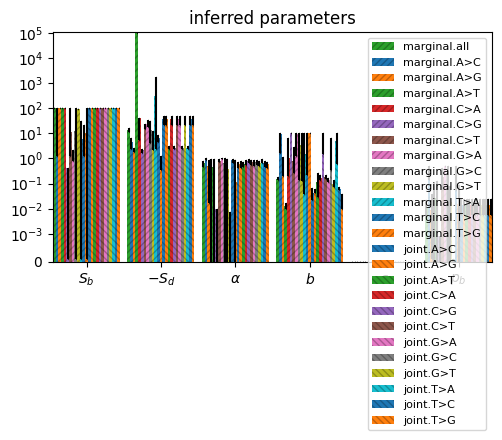

In [17]:
inf.plot_inferred_parameters()

In [29]:
inf.bootstraps.filter(regex='.*\.c0').iloc[:, 0].max()

-14.40348634304522